<a href="https://colab.research.google.com/github/nemat-al/PracticalDL_fastai/blob/main/1.Is_it_a_bird.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing fast.ai library and duckduckgo_search library**

In [2]:
!pip install -Uqq fastai duckduckgo_search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 51.5 MB/s eta 0:00:00


In [5]:
from duckduckgo_search import DDGS
from fastcore.all import *

**Searching for Birds Images**

In [9]:
with DDGS() as ddgs:
  urls = ddgs.images ('bird photos')

In [19]:
# how many urls we got?
len(urls)

97

**showing one url example of the result of search**

In [17]:
# So, what's the type of each search result?
type(urls[0])

dict

In [18]:
# How does each item  look like?
urls[0]

{'title': 'Green Bird · Free Stock Photo',
 'image': 'https://images.pexels.com/photos/1661179/pexels-photo-1661179.jpeg?cs=srgb&dl=green-bird-1661179.jpg&fm=jpg',
 'thumbnail': 'https://tse3.mm.bing.net/th?id=OIP.Ct8gRWSHnCcLr7ozTKmePAHaIp&pid=Api',
 'url': 'https://www.pexels.com/photo/green-bird-1661179/',
 'height': 2625,
 'width': 2250,
 'source': 'Bing'}

In [15]:
# first way to get the value of a key in a dictionary
urls[0]["image"]

'https://images.pexels.com/photos/1661179/pexels-photo-1661179.jpeg?cs=srgb&dl=green-bird-1661179.jpg&fm=jpg'

In [16]:
# second way to get the value of a key in a dictionary
urls[0].get("image")

'https://images.pexels.com/photos/1661179/pexels-photo-1661179.jpeg?cs=srgb&dl=green-bird-1661179.jpg&fm=jpg'

**Showing one image from the result**

In [21]:
# Let's import the download function from the fast.ai library
from fastdownload import download_url

In [20]:
dest = Path('bird.jpg')

In [25]:
download_url(urls[0]['image'],dest)

Path('bird.jpg')

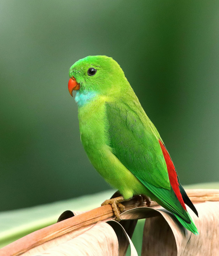

In [29]:
from fastai.vision.all import * # let's import vision related function, ex: Image
im= Image.open(dest)
im.to_thumb(256,256)

**Now, let's create a function that search for a term and return the urls, pretty much just summing up the previous cells.**

In [30]:
def search_images(term, max_images=1):
  with DDGS() as ddgs:
    urls = ddgs.images(term)
  url_results = [urls[i]["image"] for i in range(max_images)]
  return url_results

**Making the dataset of birds and forests photos**

In [65]:
# had to delete the folder to try again
# %rm -rf /content/birds_forest_data

In [66]:
# we will search for photos in 2 steps, first time for forest and the 2nd for birds
search_terms = 'forest' , 'birds'
data_path = Path('birds_forest_data')
if not os.path.isdir(data_path): # nice to check :)
  for term in search_terms:
    dest = (data_path/term)
    dest.mkdir(exist_ok = True, parents = True)
    results = search_images(f'{term} photo', 60) #looking for 60 images each
    download_images(dest, urls = results)
    resize_images(dest, max_size=400, dest=dest)

**Cheking failed images**

In [67]:
failed = verify_images(get_image_files(data_path))
failed.map(Path.unlink)

(#2) [None,None]


the fun `verify_images` use parallel function, so instead of having one core checking  all filenames, multiple cores can be used, greatly speeding up the operation.
```
def verify_image(fn):
    "Confirm that `fn` can be opened"
    try:
        im = Image.open(fn)  # uses PIL.Image to open an image at fn
        im.draft(im.mode, (32,32))
        im.load()
        return True
    except: return False

def verify_images(fns):
    "Find images in `fns` that can't be opened"
    return L(fns[i] for i,o in enumerate(parallel(verify_image, fns)) if not o)
```



`get_image_files` function returns a list of all image files in a path.

**Creating Datablock to fit the model later**

`get_y=parent_label,`

The labels (y values) is the name of the parent of each file (i.e. the name of the folder they're in, which will be bird or forest).

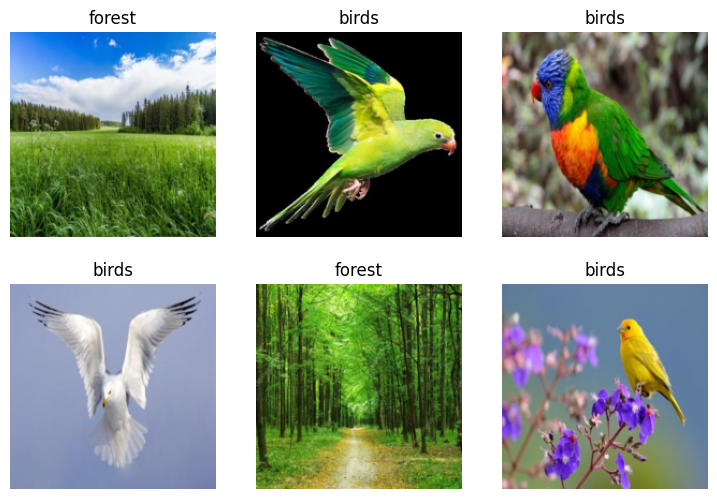

In [68]:
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42), # setting training and validation set
    get_y=parent_label,
    item_tfms=[Resize(192, method ='squish')]
).dataloaders(data_path, bs=32)
dls.show_batch(max_n=6)

In [69]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.620805,1.133716,0.409091,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.183865,0.359631,0.136364,00:11
1,0.133396,0.023993,0.000000,00:11
2,0.089269,0.003693,0.000000,00:10


In [70]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: birds.
Probability it's a bird: 1.0000
